<a href="https://colab.research.google.com/github/ibonetc/AI_Deep-Learning/blob/main/IA_DL_Autoencoder_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder convolucional

Un autoencoder es un algoritmo para compresión y descompresión de datos, con la paticularidad es capaz de reprodicir sólo datos similares a los que aprende. Lo más común es verlo como una red neuronal convolucional.

Se divide en dos componentes:

*   Encoder: Es el módulo encargado de comprimir los datos a un espacio latente
*   Decoder: Es el módulo encargado de descomprimir los datos, tratando de reconstruir la entrada original.





Los codificadores automáticos tienen pérdidas, lo que significa que las salidas descomprimidas se degradarán en comparación con las entradas originales.

En este ejemplo vamos a usar la base de datos MNIST para demostrar el uso de eliminación de ruido.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Flatten, Dense, Reshape,Conv2D,MaxPooling2D,Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

## Cargando los datos
- Acá cada imagen tiene un tamaño de 28x28, lo que significa una entrada de 784

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalizar los datos
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

print (x_train.shape)
print (x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


### Reshape

Adicionar la tercera dimensión de la imagen (En las imágenes a color no es necesario hacer esto).

train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))

Otra opción de Reshape

train_data = x_train[..., tf.newaxis]
test_data = x_test[..., tf.newaxis]

In [ ]:
train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))
print (train_data.shape)
print (test_data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Ejemplo de eliminación de ruido

Para esto, vamos a crear unas imágenes con ruido a partir de las originales, para probar que el modelo sea capaz de reconstruir la imagen.

Se creará un encoder que comprima la imagen de una dimensión de 784 a 32 y un módulo decoder que la vuelva a **reconstruir**

### Crear imágenes con ruido

In [ ]:
noisy_array = train_data + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=train_data.shape)
noisy_train_data=np.clip(noisy_array, 0.0, 1.0)

In [ ]:
noisy_array = test_data + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
noisy_test_data=np.clip(noisy_array, 0.0, 1.0)

Mostrar primeras 10 imágenes, comparadas con las generadas con ruido

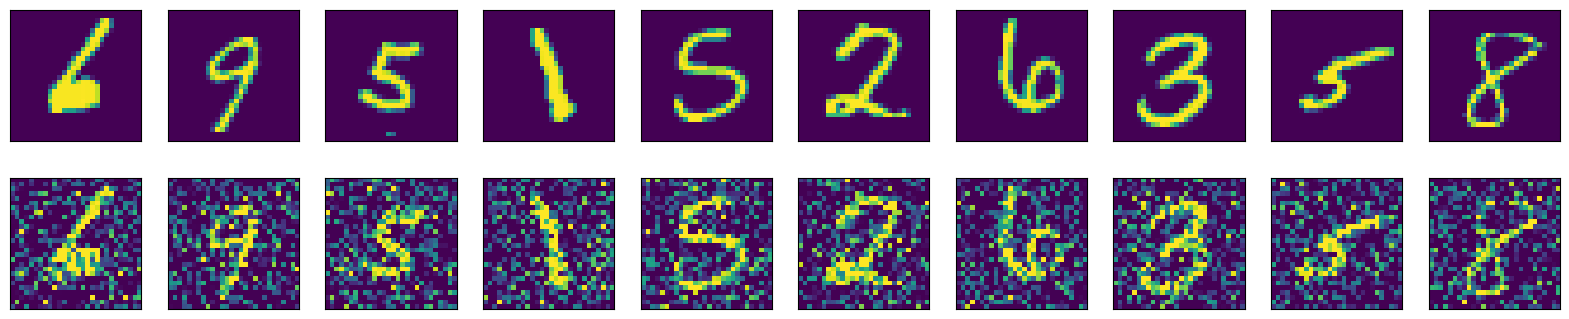

In [ ]:
indices = np.random.randint(len(train_data), size=10)
images1 = train_data[indices, :]
images2 = noisy_train_data[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
indices = np.random.randint(len(test_data), size=10)
images1 = test_data[indices, :]
images2 = noisy_test_data[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2) in enumerate(zip(images1, images2)):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### Ejemplo de modelo autoencoder

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
encoder = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
encoder = layers.MaxPooling2D((2, 2), padding="same")(encoder)
encoder = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder)
encoder = layers.MaxPooling2D((2, 2), padding="same")(encoder)

# Decoder
decoder = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoder)
decoder = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(decoder)
decoder = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(decoder)

# Autoencoder
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filepath = 'autoencoder_model.epoch{epoch:02d}-loss{val_loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.2975 - val_loss: 0.1042
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1025 - val_loss: 0.0966
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0968 - val_loss: 0.0937
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0943 - val_loss: 0.0922
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0927 - val_loss: 0.0914
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0916 - val_loss: 0.0901
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0906 - val_loss: 0.0894
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0898 - val_loss: 0.0889
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0893 - val_loss: 0.0882
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0888 - val_loss: 0.0878
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0882 - val_loss: 0.0877
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/st

In [ ]:
predictions = autoencoder.predict(noisy_test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


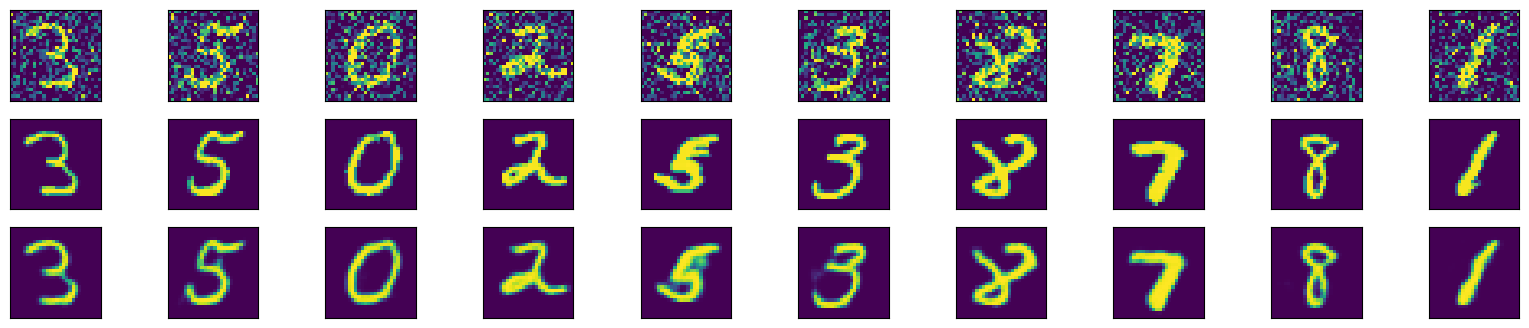

In [ ]:
indices = np.random.randint(len(noisy_test_data), size=10)
images1 = noisy_test_data[indices, :]
images2 = predictions[indices, :]
images3 = test_data[indices, :]
plt.figure(figsize=(20, 4))
for i, (images1, images2,images3) in enumerate(zip(images1, images2, images3)):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(images1.reshape(28, 28),)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, 10, i + 1 + 10)
  plt.imshow(images3.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, 10, i + 1 + 20)
  plt.imshow(images2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## Ejemplo de detección de anomalías

Para esto utilizaremos un ejemplo [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Esta base de datos tiene 5000 electrocardiogramas, donde cada uno tiene 140 puntos. Los casos están etiquetados, donde 0 significa ritmo no normal y 1 ritmo normal.

La idea es poder identificar los ritmos con anomalías (no normales).

Este ejemplo, al ser supervisado se puede tratar con cualquier método de clasificación. Aquí la idea es mostrar un ejemplo donde, partiendo de un modelo que se entrene con casos de ritmo normal, sea capaz de identificar cuando no es normal.

### Cargar los datos

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Como se puede ver la columna 140 tiene la etiqueta, y de la 0 a la 139 están los puntos de la señal del electrocardiograma.

In [ ]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2,stratify=labels)

In [ ]:
print(np.unique(train_labels,return_counts=True))
print(np.unique(test_labels,return_counts=True))

(array([0., 1.]), array([1663, 2335]))
(array([0., 1.]), array([416, 584]))


### Normalizar los datos

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

### Preparar los datos

Como vamos a entrenar el modelo sólo con los datos normales, entonces vamos a separar los que la etiqueta es 1 (label=1)

In [ ]:
train_labels

array([1., 1., 0., ..., 1., 0., 0.])

In [ ]:
train_labels==1

array([ True,  True, False, ...,  True, False, False])

In [ ]:
one_train_labels=train_labels==1
one_test_labels=test_labels==1

In [ ]:
normal_train_data = train_data[one_train_labels]
normal_test_data = test_data[one_test_labels]

anomalous_train_data = train_data[~one_train_labels]
anomalous_test_data = test_data[~one_test_labels]

Ejemplo de una señal normal y otra con anomalía

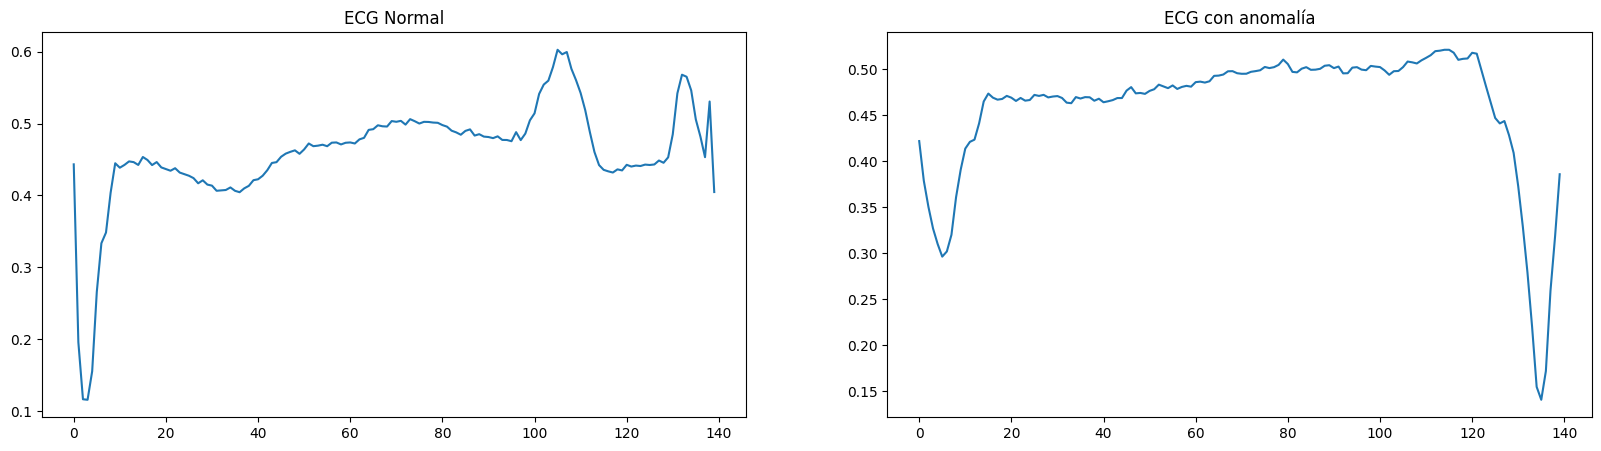

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(140), normal_train_data[0])
plt.title("ECG Normal")
plt.subplot(1, 2, 2)
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("ECG con anomalía")
plt.show()

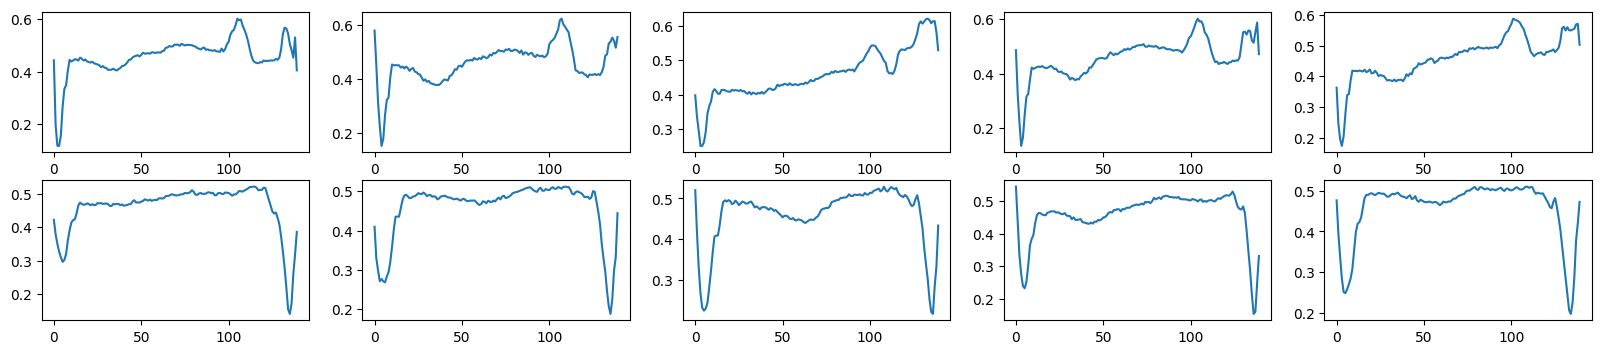

In [ ]:
n=5
plt.figure(figsize=(20, 4))
for i, (s1, s2) in enumerate(zip(normal_train_data[0:n], anomalous_train_data[0:n])):
  ax = plt.subplot(2, n, i + 1)
  plt.plot(np.arange(140), s1)
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(np.arange(140), s2)
plt.show()

In [ ]:
input= Input(shape=(140,))
encoder = Dense(32, activation="relu")(input)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)

decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(decoder)
decoder = Dense(140, activation="sigmoid")(decoder)

autoencoder=Model(input, decoder)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=50,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - loss: 0.0462 - val_loss: 0.0438
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0446 - val_loss: 0.0428
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0429 - val_loss: 0.0419
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0411 - val_loss: 0.0409
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0391 - val_loss: 0.0401
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0370 - val_loss: 0.0391
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0350 - val_loss: 0.0384
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0328 - val_loss: 0.0376
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0309 - val_loss: 0.0370
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293 - val_loss: 0.0364
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0277 - val_loss: 0.0357
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0263 - val_loss: 0.0352
Epoch 1

In [ ]:
autoencoder.save("autoencoder.keras")

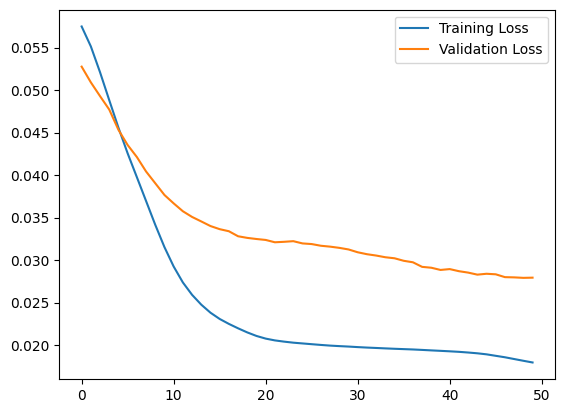

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Plot de una señal sin anomalía y una con anomalías

Ejemplo de señal normal:

In [ ]:
reconstructions = autoencoder(test_data)

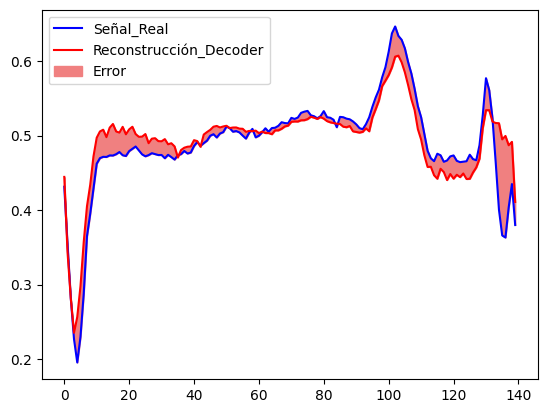

In [ ]:
plt.plot(normal_test_data[0], 'b')
plt.plot(reconstructions[0], 'r')
plt.fill_between(np.arange(140), reconstructions[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Señal_Real", "Reconstrucción_Decoder", "Error"])
plt.show()

Ejemplo de señal con anomalía

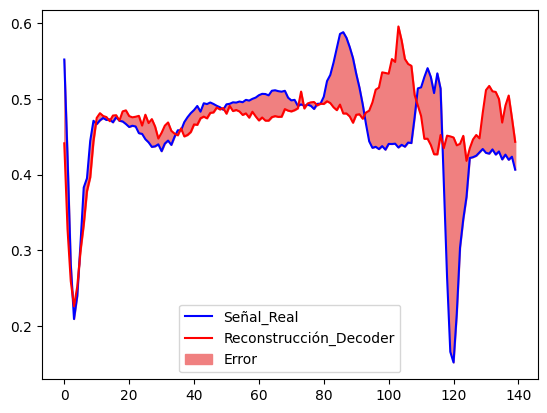

In [ ]:
reconstructions = autoencoder(anomalous_test_data)
plt.plot(anomalous_test_data[0], 'b')
plt.plot(reconstructions[0], 'r')
plt.fill_between(np.arange(140), reconstructions[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Señal_Real", "Reconstrucción_Decoder", "Error"])
plt.show()

### Dectección de anomalías


Para la detección de anomalía vamos a usar el error de la reconstrucción. Para esto podemos usar un umbral, que pudiera ser el error medio promedio para los ejemplos que tienen ritmo normal, con cierta desviación estándar.

Podemos estimar que la señal tiene anomalía si el error de reconstrucción de una señal está está por encima de ese umbral.


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


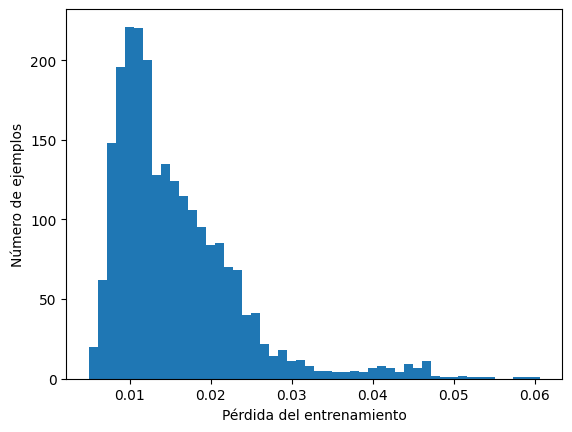

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel('Pérdida del entrenamiento')
plt.ylabel('Número de ejemplos')
plt.show()

Usando como umbral la media de la pérdida más la desviación estándar.

In [ ]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
print("Umbral: ", threshold)

Umbral:  0.03147614188492298


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


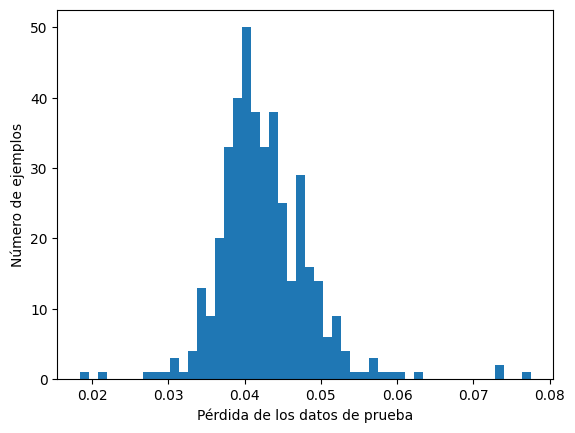

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Pérdida de los datos de prueba")
plt.ylabel("Número de ejemplos")
plt.show()

In [ ]:
# Predecir
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
predictions= tf.math.less(loss, threshold)

In [ ]:

print("Accuracy = {}".format(accuracy_score(test_labels, predictions)))
print("Precision = {}".format(precision_score(test_labels, predictions)))
print("Recall = {}".format(recall_score(test_labels, predictions)))

Accuracy = 0.964
Precision = 0.9858156028368794
Recall = 0.952054794520548


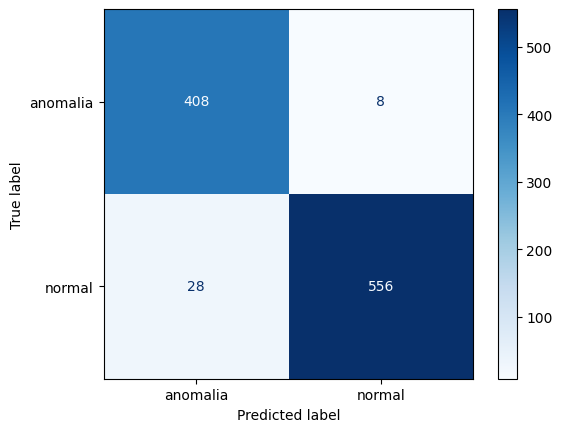

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
cm = confusion_matrix(test_labels, predictions)
classes=['anomalia', 'normal']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
print(classification_report(test_labels, predictions, target_names=classes))

              precision    recall  f1-score   support

    anomalia       0.94      0.98      0.96       416
      normal       0.99      0.95      0.97       584

    accuracy                           0.96      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.96      0.96      1000



### Usando autoencoder con LSTM

In [ ]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model

input = Input(shape=(140, 1))

#encoder = LSTM(32, activation="relu", return_sequences=True)(input)
encoder = LSTM(64, activation="relu")(input)  # Última capa del encoder, sin return_sequences

decoder = RepeatVector(140)(encoder)

#decoder = LSTM(32, activation="relu", return_sequences=True)(decoder)
decoder = LSTM(64, activation="relu", return_sequences=True)(decoder)

output = TimeDistributed(Dense(1, activation="sigmoid"))(decoder)

autoencoder = Model(inputs=input, outputs=output)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 140, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_4 (RepeatVector)       │ (None, 140, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 140, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 140, 1)              │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 0.0461 - val_loss: 0.0440
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - loss: 0.0418 - val_loss: 0.0412
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0368 - val_loss: 0.0382
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0357 - val_loss: 0.0368
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0349 - val_loss: 0.0364
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0340 - val_loss: 0.0366
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0351 - val_loss: 0.0343
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0321 - val_loss: 0.0347
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0389 - val_loss: 0.0408
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0411 - val_loss: 0.0364
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0370 - val_loss: 0.0375
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

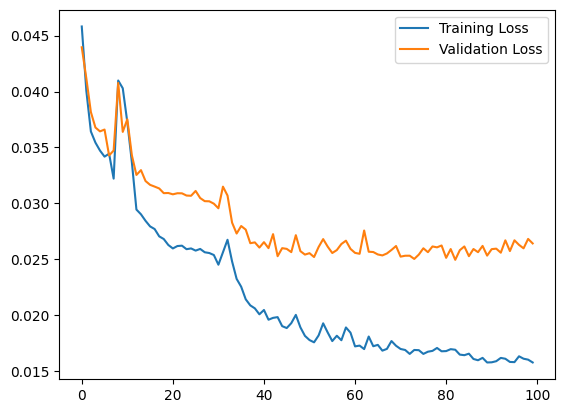

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step


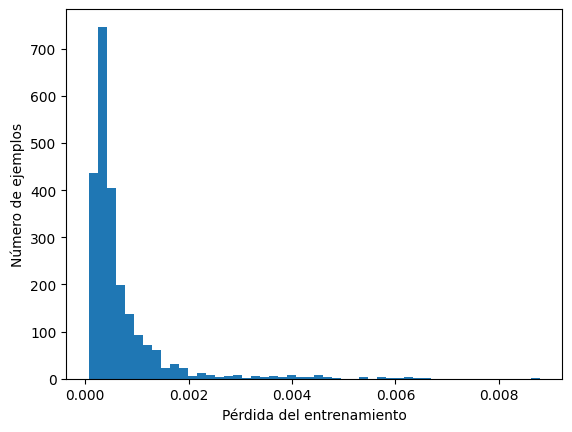

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel('Pérdida del entrenamiento')
plt.ylabel('Número de ejemplos')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


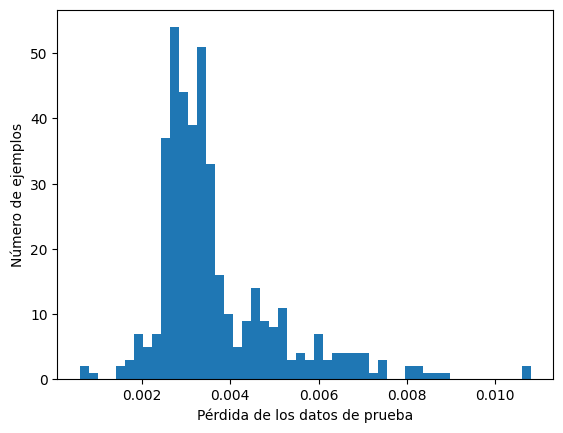

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mse(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Pérdida de los datos de prueba")
plt.ylabel("Número de ejemplos")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
print("Umbral: ", threshold)

Umbral:  0.0023252529790624976


In [ ]:
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mse(reconstructions, test_data)
predictions= tf.math.less(loss, threshold)
print("Accuracy = {}".format(accuracy_score(test_labels, predictions)))
print("Precision = {}".format(precision_score(test_labels, predictions)))
print("Recall = {}".format(recall_score(test_labels, predictions)))

Accuracy = 0.949
Precision = 0.9586919104991394
Recall = 0.9537671232876712


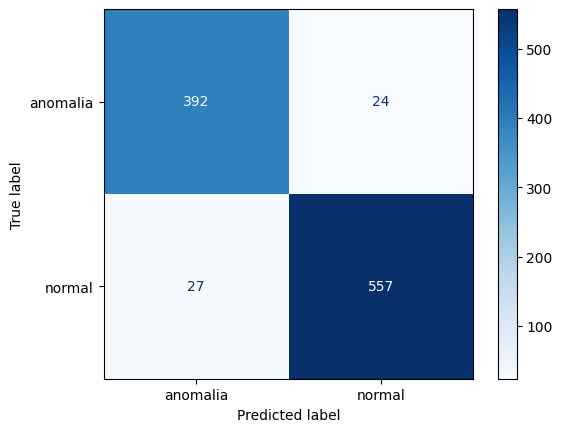

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
cm = confusion_matrix(test_labels, predictions)
classes=['anomalia', 'normal']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
print(classification_report(test_labels, predictions, target_names=classes))

              precision    recall  f1-score   support

    anomalia       0.94      0.94      0.94       416
      normal       0.96      0.95      0.96       584

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

